In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

+ Download dữ liệu CIFAR10 sau đó chia thành 2 tập dữ liệu train và validation.
+ Chuẩn hóa dữ liệu với mean = 0.5 và std = 0.5

In [16]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5, ), std = (0.5, ))])
trainset = torchvision.datasets.CIFAR10(root='D:/Downloads/DecisionTree_RandomForest', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=8, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='D:/Downloads/DecisionTree_RandomForest', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


+ Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing

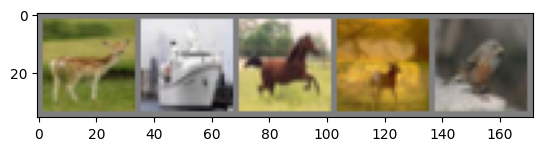

In [17]:
def imshow(img):
    img = img * 0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    imshow(torchvision.utils.make_grid(images[:5]))
    break

+ Xây dựng model MLP cơ bản để train tập dữ liệu CIFAR10

In [19]:
def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    return model

+ Khởi tạo hàm loss function và phương thức optimizer

In [20]:
n_features = 32 * 32 * 3 
model = getModel(n_features)
lr = 0.01
optim = SGD(params = model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

+ Xây dựng hàm đánh giá model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Chuẩn bị dữ liệu với Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

# Định nghĩa mô hình CNN với Dropout
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)  # Thêm Dropout

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Thêm Dropout
        x = self.fc2(x)
        return x

model = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

n_epochs = 10  # Tăng số lượng epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

def evaluate(model, dataloader, loss_fn):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_loss /= len(dataloader)
    return test_loss, accuracy

best_accuracy = 0.0

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
    
    scheduler.step()


100%|██████████| 170498071/170498071 [01:01<00:00, 2794869.13it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10], Loss: 1.6175, Accuracy: 40.73%, Test Loss: 1.2963, Test Accuracy: 53.23%
Epoch [2/10], Loss: 1.3200, Accuracy: 52.34%, Test Loss: 1.0560, Test Accuracy: 62.38%
Epoch [3/10], Loss: 1.1863, Accuracy: 57.68%, Test Loss: 0.9742, Test Accuracy: 65.78%
Epoch [4/10], Loss: 1.1049, Accuracy: 60.58%, Test Loss: 0.9010, Test Accuracy: 68.23%
Epoch [5/10], Loss: 1.0426, Accuracy: 63.05%, Test Loss: 0.8690, Test Accuracy: 70.16%
Epoch [6/10], Loss: 0.9578, Accuracy: 66.26%, Test Loss: 0.8241, Test Accuracy: 70.87%
Epoch [7/10], Loss: 0.9327, Accuracy: 67.01%, Test Loss: 0.8021, Test Accuracy: 71.87%
Epoch [8/10], Loss: 0.9198, Accuracy: 67.67%, Test Loss: 0.7979, Test Accuracy: 72.09%
Epoch [9/10], Loss: 0.9062, Accuracy: 68.19%, Test Loss: 0.7835, Test Accuracy: 72.62%
Epoch [10/10], Loss: 0.9006, Accuracy: 68.16%, Test Loss: 0.7751, Test Accuracy: 72.78%


+ Bắt đầu training và đánh giá model.

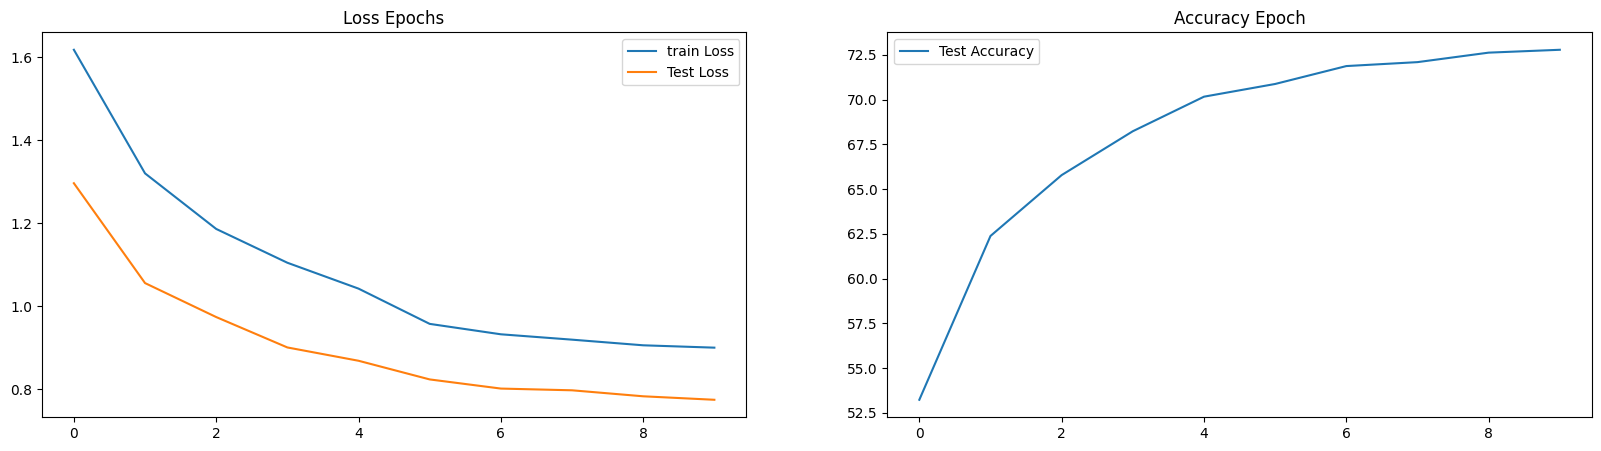

In [2]:
import matplotlib.pyplot as plt

# Assuming 'train_losses', 'test_losses', and 'test_accuracies' are already defined

plt.figure(figsize=(20, 5))

plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label='train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()

plt.show()


+ Dưới đây là bài tập về code from scratch

In [3]:

def zScoreScaling(tensor):
    """
    Thực hiện chuẩn hóa dữ liệu theo phương pháp Z-score.

    Args:
        tensor: Tensor cần chuẩn hóa.

    Returns:
        Tensor đã được chuẩn hóa.
    """

    mean = torch.mean(tensor)
    std = torch.std(tensor)
    return (tensor - mean) / std

In [4]:
def minMaxScaling(tensor):
    """
    Thực hiện chuẩn hóa dữ liệu theo phương pháp Min-Max.

    Args:
        tensor: Tensor cần chuẩn hóa.

    Returns:
        Tensor đã được chuẩn hóa.
    """

    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    return (tensor - min_val) / (max_val - min_val)

In [5]:
class Linear:
 import torch

class Linear:
    def __init__(self, in_features, out_features):
        self.weight = torch.randn(out_features, in_features)
        self.bias = torch.randn(out_features)

    def forward(self, x):
        return torch.matmul(x, self.weight.T) + self.bias

# Tạo một đối tượng của lớp Linear
linear = Linear(3, 2)  # 3 đặc trưng đầu vào, 2 đặc trưng đầu ra

# Tạo tensor đầu vào
tensor = torch.tensor([1.0, 2.0, 3.0])

# Thực hiện phép biến đổi tuyến tính
output = linear.forward(tensor)

# In kết quả
print(output)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")
    

tensor([ 1.4177, -4.8040])
Weight = tensor([[ 0.0221,  0.6556, -0.0171],
        [ 1.4658, -1.9796,  0.1582]])
Bias = tensor([ 0.1356, -2.7852])


In [6]:
tensor = torch.tensor([
    [1.0, 2.0, 3.0], 
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])
zscore = zScoreScaling(tensor)
min_max = minMaxScaling(tensor)
print(zscore)
print(min_max)


tensor([[-1.4606, -1.0954, -0.7303],
        [-0.3651,  0.0000,  0.3651],
        [ 0.7303,  1.0954,  1.4606]])
tensor([[0.0000, 0.1250, 0.2500],
        [0.3750, 0.5000, 0.6250],
        [0.7500, 0.8750, 1.0000]])


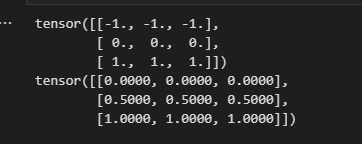

In [7]:
tensor = torch.tensor([1.0, 2.0, 3.0])
linear = Linear(3, 2)
out = linear.forward(tensor)
print(out)
print(f"Weight = {linear.weight}")
print(f"Bias = {linear.bias}")

tensor([1.7518, 0.1316])
Weight = tensor([[-0.2824, -0.4490,  1.3611],
        [-1.9570, -0.9149,  1.2283]])
Bias = tensor([-1.1510,  0.2333])
